# <font color='navy'> <b> SPICE Netlist</b></font>

Netlist je textový súbor, obsahujúci popis zapojenia pre simuláciu vo formáte SPICE. Tento môžeme vytvoriť niekoľkými spôsobmi 

* pre jednoduché zapojenia ručne - priamo v prostredí Jupyter notebooku alebo v ľubovolnom textovom editore pri dodržaní syntaxe [SPICE](http://bwrcs.eecs.berkeley.edu/Classes/IcBook/SPICE/UserGuide/description_fr.html)

* exportom z pomocou grafického editora schém *KiCad*

* pomocou ľubovolného iného grafického editora schém, ktorý umožňuje generovanie netlistu, zoznam editorov a prostredí je uvedený na stránke [simulátora ngspice](http://ngspice.sourceforge.net/resources.html)


## <font color='purple'> <b> Vytvorenie netlistu </b></font>

Pre jednoduché obvody môžeme vyvoriť netlist priamo v prostredí Jupyter notebooku. Netlist vytvoríme ako textový reťazec, ktorý uložíme do súboru. 

Základné konvencie pre tvorbu netlistu:
    
* **Prvý riadok** musí byť v súlade s konvenciou SPICE komentár a musí začínať **\***
* **Posledný riadok** musí obsahovať príkaz .END, všetko čo sa nachádza za týmto príkazom je ignorované

* Referenčný uzol - zem musí mať označenie 0

* Označenie uzlov môže byť numerické alebo textové.

Prvé písmeno v označení komponentu definuje jeho typ:

    C Capacitor
    D Diode
    F Current-controlled current source (CCCs)
    G Voltage-controlled current source (VCCS)
    I Current source
    J Junction field effect transistor (JFET)
    L Inductor
    M Metal oxide field effect transistor (MOSFET)
    Q Bipolar junction transistor (BJT)
    R Resistor
    X Subcircuit (for details see below)
    Z Metal semiconductor field effect transistor (MESFET)
    
Nasledujúci netlist popisuje zapojenie jednoduchého RC obvodu, vytvoríme ho ako textový reťazec a zapíšeme ho do súboru. Súčasťou netlistu je príkaz určujúci typ a parametre simulácie *.AC ...*

In [1]:
netlist='* Komentar     \n' +\
'R1 1 2 1k              \n' +\
'C1 2 0 1uF             \n' +\
'V1 1 0 dc 0 ac 1       \n' +\
'.AC DEC 100 10Hz 1MEG  \n' +\
'.END                   \n'

fp = open('test.cir', 'w')
fp.write(netlist)
fp.close()

Po spusteni programu v bunke notebooku je netlist uložený v textovom súbore v adresári notebooku.

## <font color='purple'> <b> Simulácia </b></font>

Pre simuláciu v prostredí notebooku použijeme knižnicu *kSim* (umiestnenú v adresári *./py*) a vytvoríme simulačný objekt*, ktorý volá systémovým volaním simulátor *ngspice*. Po ukončení simulácie je vytvorený binárny súbor typu *.raw*, ktorý obsahuje výsledky simulácie.

Zo súboru s výsledok simulácie sú hodnoty pre uzly zapojenia konvertované slovník Pythonu, premenné reprezentujúce prúd a napätie pre každý uzol sú viazané k označeniu uzlov obvodu (1,2). 

In [2]:
import sys
sys.path.append('./py')
from ksim import *      

g = kSim('test.cir')    # vytvorenie objektu simulacie
g.sim()                 # spustenie simulacie
[q for q in g.yData]    # tlac zoznamu premennych (komplexnych pre .AC)

['v(1)', 'v(2)', 'i(v1)']

Výsledkom simulácie je slovník premenných *yData*, ktorý obsahuje dáta komplexné v komplexnom tvare pre prúdy a napätia v uzloch obvodu. Nezávislá premenná (čas, frekvencia, napätie, prúd - podľa typu simulácie) je uložená v premennej *xData*.

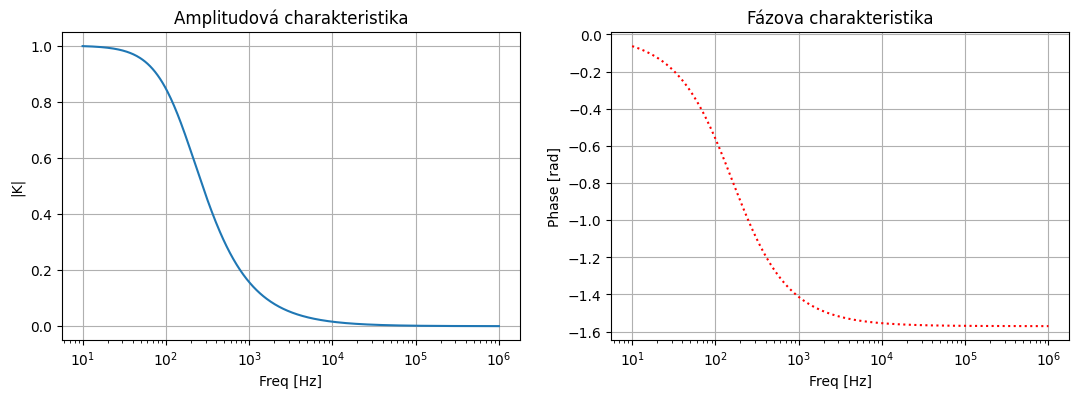

In [3]:
%matplotlib inline
import pylab as plt

fig = plt.figure(figsize=(13, 4)) 

p1 = plt.subplot(121)
p1.semilogx(g.xData, abs(g.yData['v(2)']))
p1.set_xlabel('Freq [Hz]')
p1.set_ylabel('|K|')
p1.set_title('Amplitudová charakteristika')
p1.grid()

p2 = plt.subplot(122)
p2.semilogx(g.xData, angle(g.yData['v(2)']), 'r:')
p2.set_xlabel('Freq [Hz]')
p2.set_ylabel('Phase [rad]')
p2.set_title('Fázova charakteristika')
p2.grid()

plt.show()

## <font color='purple'> <b> Vytvorenie a použitie parametrického netlistu </b> </font>

Pri navrhovaní obvodov často vychádzame zo štandarného zapojenia, v ktorom ale potrebujeme definovať hodnoty použitých komponentov. Predprocesor *kSim* umožňuje parametrizovať vytvorený netlist,  môžeme používať parametre a zároveň ho môžeme modifikovať a rozširovať. 

### <font color='teal'> <b> Výpočet impedancie sériového rezonančného obvodu </b></font>

V nasledujúcom príklade vytvoríme parametrický netlist pre sériový obvod napájaný zdrojom napätia s výstupným odporom ROUT a tvorený indučnosťou L1 s odporom R1 a kapacitou C1.

<img src="./examples/0010_netlist/01_netlist.png" width="400">

Parametrom sú hodnoty komponentov, tieto sú deklarované menom uzatvoreným v zložených zátvorkách **{meno_parametra}**.

In [6]:
%reset -s -f

nets = [
    '* Komentar',               # vytvorenie netlistu ako pola retazcov
    'V1 IN 0 DC 0 AC 1',
    'R1 IN OUT {rout}',         # komponenty s parametrami
    'L1 OUT A {inductor}',
    'R2 A B {resistor}',
    'C1 B 0 {capacitor}',
    '.END'
]

fp = open('test_rlc.net', 'w')  # zapis do suboru
for s in nets:
    fp.write(s + '\n')
fp.close()

V simulácii nás bude zaujímať, ako sa mení impedancia obvodu pri zmene kvality rezonančného obvodu, ktorej zodpovedá zmena hodnoty sériového odporu indukčnosti. 

Hľadanú impedanciu určíme z podielu napätia v uzle OUT a prúdu pretekajúceho rezonančným obvodom, ktorý určíme z rozdielu napätí na odpore ROUT. Hodnoty parametra menime pomocou metódy *setPAR()*

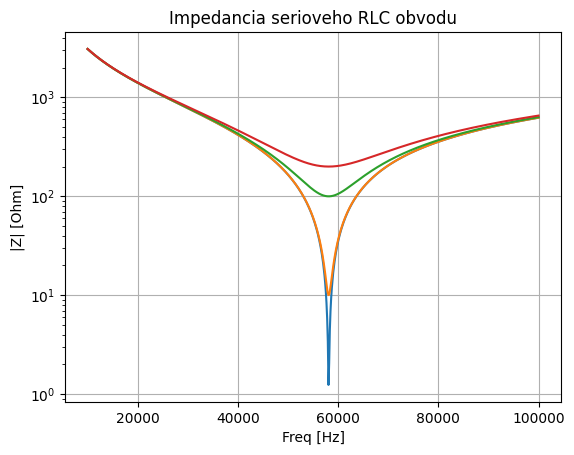

In [8]:
%matplotlib inline
import pylab as plt
import sys
sys.path.append('./py')
from ksim import *  

g = kSim('test_rlc.net')                           # vytvorenie objektu simulacie


g.setPAR('rout', 100)                # nastavenie hodnot parametrov a typu simulacie 
g.setPAR('inductor', 1.5e-3)
g.setPAR('capacitor', 5e-9)
g.setAC(1e4, 1e5, number=1000, stype='DEC' )

for res in [1, 10, 100, 200]:         # zmena parametra v cykle
    g.setPAR('resistor', res)
    g.sim()
    z = abs(g.yData['v(out)']) / ( (abs(g.yData['v(in)'] - g.yData['v(out)'] ) ) /100)
    plt.semilogy(g.xData, z, label=str(res))
    
plt.xlabel('Freq [Hz]')
plt.ylabel('|Z| [Ohm]')
plt.title('Impedancia serioveho RLC obvodu')
plt.grid()
